A global map of human gene expression
http://europepmc.org/articles/PMC2974261

Data in ArrayExpress/ 

In [26]:
import pandas as pd
import numpy as np
import h5py

In [2]:
fd = pd.read_csv('ArrayExpress/E-MTAB-62.sdrf.txt', delimiter='\t')

In [3]:
fd.describe()

,Source Name,Characteristics[OperatorVariation],Characteristics[DataSource],Characteristics[4 meta-groups],Characteristics[15 meta-groups],Characteristics[369 groups],Characteristics[groups with 10 and more replicates],Characteristics[Blood/NonBlood meta-groups],Characteristics[Organism],Characteristics[OrganismPart],...,Protocol REF,Derived Array Data Matrix File,Comment [Derived ArrayExpress FTP file],Factor Value[4 meta-groups],Factor Value[15 meta-groups],Factor Value[369 groups],Factor Value[Blood-NonBlood meta-groups],Factor Value[6 meta-groups],Factor Value[4 groups from blood to incompletely diff],Factor Value[96 groups]
count,5372,5372,5372,5372,5372,5372,5372,5372,5372,5372,...,5372,5372,5372,5372,5372,5372,5372,5372,5372,5372
unique,5372,163,206,4,15,369,97,2,2,131,...,1,1,1,4,15,369,2,7,4,97
top,GSM123775.CEL,"Justin,,Lamb",GSE5258,neoplasm,solid tissue neoplasm cell line,breast cancer,,non blood,Homo sapiens,blood,...,P-MTAB-2072,hgu133a_rma_okFiles_080619_MAGETAB.csv,ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...,neoplasm,solid tissue neoplasm cell line,breast cancer,non blood,hematopoietic system,the rest,
freq,1,324,324,2315,831,672,764,3450,5369,1089,...,5372,5372,5372,2315,831,672,3450,1854,2976,764


In [4]:
fd['Characteristics[4 meta-groups]'].unique()

array(['cell line', 'neoplasm', 'normal', 'disease'], dtype=object)

In [5]:
print np.where(fd['Characteristics[4 meta-groups]']=='normal')[0].shape
normals = fd[fd['Characteristics[4 meta-groups]']=='normal']['Source Name'].tolist()
#print normals

(1033,)


1033 entries have meta-group "normal"

In [6]:
with open('ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv', 'r') as f:
    header = f.readline()
    f.close()

In [7]:
#print header.split('\t')[:10]
#print normals[:10]
cols = [i for (i, x) in enumerate(header.split("\t")) if x.lstrip('"').rstrip('"') in normals]
print len(cols)

1033


In [8]:
data = np.loadtxt('ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv', 
          skiprows=2, delimiter='\t', usecols=cols)

In [9]:
data.shape

(22283, 1033)

In [11]:
%matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg


In [12]:
plt.plot(range(data.shape[1]), data[0,:])
plt.plot(range(data.shape[1]), data[1,:], 'g')

In [22]:
# Get gene names
gene_names = np.loadtxt('ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv', 
                        usecols=[0], dtype='str')
gene_names = [x.lstrip('"').rstrip('"') for x in gene_names]
print gene_names[10]

### Map E-MTAB-62 data

In [74]:
import pickle
import sys
sys.path.append('NormalisingData/projectX/')
from ExpressionDataset import ExpressionDataset
import mapData

In [61]:
# Transform hgu133a_rma_okFiles_080619_MAGETAB.csv into .dat
# match the format of NormalisingData/R_playground/U133AnormalizedExpression.dat
csv_data_fname = 'ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv'
# first line = sample names, tab separated, between " quotes (e.g  "1102960569.CEL"  )
# second line = to be ignored
# first column = gene names, between " quotes (e.g. "1255_g_at")

D = np.hstack((fcol.reshape(fcol.shape[0], 1), data.T))

datafile = 'ArrayExpress/postproc/hgu133a_rma_okFiles_080619_MAGETAB.dat'
# first line = gene names, space-separated, between " quotes (e.g. "1255_g_at")
# first column = GSM names, between " quotes (e.g. "GSM107074.CEL.gz")
np.savetxt(datafile, D, fmt='%s', comments='',
           delimiter=" ", header=" ".join(['"%s"' % x for x in gene_names[2:]]))

In [62]:
# Read the data
(affyIDs, patientIDs, exprMatrix, exprs) = mapData.readExpressionData(datafile)

In [64]:
### Create an ExpressionDataset object
cohort_name = 'MTAB-62'
ds = ExpressionDataset(cohort_name, exprMatrix, np.array(affyIDs), np.ones(len(patientIDs)),
                      np.array(patientIDs), checkNormalization=False, checkClassLabels=False)

In [82]:
### Map from Affymetrix probe set ID to Entrez gene ID
reload(mapData)
print "Map AffyIDs to Entrez gene IDs"
map_probe_ids_to_gene_ids = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/HG-U133A.na32.annot.csv'
map_fname = 'ArrayExpress/postproc/HG-U133A.pickle'
best_map_entrez_affy = mapData.ProbeToGeneID(map_probe_ids_to_gene_ids, ds, map_fname)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))

idx = np.argwhere(np.in1d(ds.geneLabels, best_map_affy_entrez.keys()))[:, 0]

ds_clean_probes = ds.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(ds_clean_probes.geneLabels)):
    ds_clean_probes.geneLabels[ix] = best_map_affy_entrez[ds_clean_probes.geneLabels[ix]]

print "Mean-center"
ds_clean_probes.expressionData = ds_clean_probes.expressionData - ds_clean_probes.expressionData.mean(0)

### Dump clean data
res_dir = 'ArrayExpress/postproc'
ds_clean_probes = ExpressionDataset(cohort_name, ds_clean_probes.expressionData, ds_clean_probes.geneLabels, 
                                    ds_clean_probes.patientClassLabels, 
                                    ds_clean_probes.patientLabels, checkNormalization=False, checkClassLabels=False)
pickle.dump(ds_clean_probes, open('%s/%s_data.pickle' % (res_dir, cohort_name), 'wb'))

Map AffyIDs to Entrez gene IDs
Columns in mapping file:
['"Probe Set ID', 'GeneChip Array', 'Species Scientific Name', 'Annotation Date', 'Sequence Type', 'Sequence Source', 'Transcript ID(Array Design)', 'Target Description', 'Representative Public ID', 'Archival UniGene Cluster', 'UniGene ID', 'Genome Version', 'Alignments', 'Gene Title', 'Gene Symbol', 'Chromosomal Location', 'Unigene Cluster Type', 'Ensembl', 'Entrez Gene', 'SwissProt', 'EC', 'OMIM', 'RefSeq Protein ID', 'RefSeq Transcript ID', 'FlyBase', 'AGI', 'WormBase', 'MGI Name', 'RGD Name', 'SGD accession number', 'Gene Ontology Biological Process', 'Gene Ontology Cellular Component', 'Gene Ontology Molecular Function', 'Pathway', 'InterPro', 'Trans Membrane', 'QTL', 'Annotation Description', 'Annotation Transcript Cluster', 'Transcript Assignments', 'Annotation Notes"\n']
Replace AffyIDs with gene IDs
Mean-center


In [84]:
### Convert pickle data into hdf5 format
from ConvertPickleData import EmitDataset
res_dir = 'ArrayExpress/postproc'

data_clean = pickle.load(open('%s/%s_data.pickle' % (res_dir, cohort_name)))

hdf5_fname = '%s/%s.h5' % (res_dir, cohort_name)
hdf5_f = h5py.File(hdf5_fname, 'w')
EmitDataset(data_clean, None, hdf5_f)
hdf5_f.close()  

Adding dataset: MTAB-62
['Entrez_780' 'Entrez_5982' 'Entrez_7318' ..., 'Entrez_11033' 'Entrez_4034'
 'Entrez_54869']


## Look at gene vs. gene plots in ACES-DMFS and E-MTAB-62 data

In [120]:
# Get ACES data
f = h5py.File("ACES/experiments/data/U133A_combat.h5")
X = f['U133A_combat_RFS']['ExpressionData']
print X.shape
aces_gene_names =  f['U133A_combat_DMFS']['GeneLabels']
print aces_gene_names[20]

(1616, 12750)
Entrez_6207


In [90]:
# Get reference data
f = h5py.File("ArrayExpress/postproc/MTAB-62.h5")
X_ref = f['MTAB-62']['ExpressionData']
print X_ref.shape
ref_gene_names =  f['MTAB-62']['GeneLabels']


(1033, 12750)


In [121]:
# Reorder reference data so that genes map those in ACES data
# reordered_genes[0] = index of aces_gene_names[0] in ref_gene_names
ref_gene_names = list(ref_gene_names)
ref_gene_names_dict = dict([(a, ix) for ix, a in enumerate(ref_gene_names)]) # name:idx
#print ref_gene_names_dict
reordered_genes = [ref_gene_names_dict[a] for a in aces_gene_names]
#print ref_gene_names[reordered_genes[20]]
#X_ref = X_ref[:, reordered_genes]
X_ref_reordered = np.array(X_ref)
for ix in range(X_ref.shape[1]):
    X_ref_reordered[:, ix] = X_ref[:, reordered_genes[ix]]

In [89]:
%pylab inline
orange_color = '#d66000'
blue_color = '#005599'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [127]:
n, p = X_ref_reordered.shape
print n, p
reg_w = np.linalg.lstsq(np.array([X_ref_reordered[:, 1], np.ones(n) ]).T, X_ref_reordered[:, 81])[0]

1033 12750


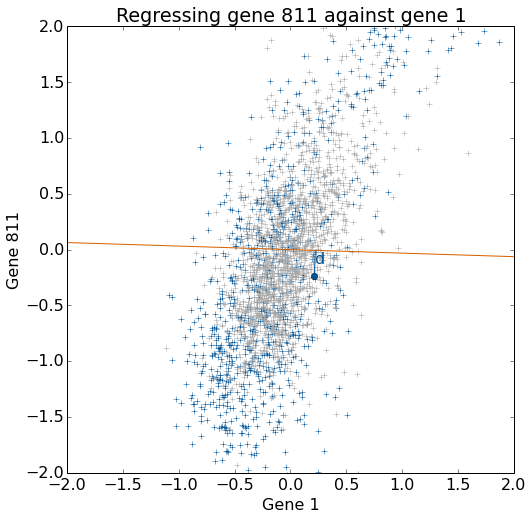

In [132]:
[w0, w1] = reg_w

rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(X_ref_reordered[:, 1], X_ref_reordered[:, 811], marker="+", ls='', color=blue_color)
plot(X[:, 1], X[:, 811], marker="+", ls='', color='darkgrey')

plot(np.arange(-2, 2.1, 0.1),  w0*np.arange(-2, 2.1, 0.1) + w1, ls='-', color=orange_color)
xlim(-2, 2)
ylim(-2, 2)
xlabel('Gene 1')
ylabel('Gene 811')
title('Regressing gene 811 against gene 1')

# single out one point
sample_idx = 473
x0 = X[sample_idx, 1]
y0 = X[sample_idx, 811]
plot(x0, y0, marker="o", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('ArrayExpress/postproc/regline_example.pdf', bbox='tight_layout')

## What follows is junk

In [ ]:
### STEP 1 (do we need this?): Compute correlations between samples
#import pickle
#import calculatePC
#import ensure_dir
#print "Computing correlation between samples (takes time)"
#res_dir = 'results/heatmaps'
#ensure_dir(res_dir)
#corr, corr_hist = calculatePC(ds.expressionData)
#pickle.dump(corr, open('%s/%s_corr_matrix.pickle' % (res_dir, cohort_name), 'wb'))

#corr_mean, corr_hist_mean = calculatePC(ds_mean.expressionData)
#pickle.dump(corr_mean, open('%s/%s_corr_matrix_mean.pickle' % (res_dir, cohort_name), 'wb'))


### STEP 2: Detect and remove similar samples (possible duplicates).
sim_thresh = 0.9 # similarity threshold: remove samples that show high correlation
data = pickle.load(open("%s/%s_data.pickle")) # combatData.pickle

# TODO IDENTIFY SIMILAR PAIRS    
print "Cohort has %d similar pairs" % len(sim_pairs)
    
remove_samples = removeSamplesRandomElimination(sim_pairs)   
print "Removing %d samples" % len(remove_samples)

# find indices of the removed samples in the merged dataset
try:
    remove_samples_idx = np.argwhere(np.in1d(data.patientLabels, remove_samples))[:, 0]
except:
    remove_samples_idx = np.argwhere(np.setmember1d(data.patientLabels, remove_samples))[:, 0]
    
patient_idx = range(len(data.patientLabels))
ds_clean_samples = data.extractPatientsByIndices(("ALL_%s_cleanSamples" % cohort_name),
                                                 list(set(patient_idx).difference(remove_samples_idx)), 
                                                 False, False)    

print "Map AffyIDs to Entrez gene IDs"
mapProbeIdsToGeneIds = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/HG-U133A.na32.annot.csv'
best_map_entrez_affy = ProbeToGeneID(mapProbeIdsToGeneIds, ds_clean)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))
try:
    idx = np.argwhere(np.in1ds(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
except:
    idx = np.argwhere(np.setmember1d(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
data_clean = ds_clean_samples.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(data_clean.geneLabels)):
    data_clean.geneLabels[ix] = best_map_affy_entrez[data_clean.geneLabels[ix]]

print "Mean-center"
data_clean.expressionData = data_clean.expressionData - data_clean.expressionData.mean(0)

# save to pickle
pickle.dump(data_clean, open('%s/%s_all_data.pickle' % (res_dir, cohort_name), 'wb')    

In [39]:
import pylab
from matplotlib.backends.backend_pdf import PdfPages
def compute_pca(matrix, plot_title, plot_fname):
    """Compute PCA of a matrix.
    
    Parameters
    ----------
    matrix: np.array
        covariance matrix or data matrix (variables x observations).
    
    plot_title: string
        Title of plot.
        
    plot_fname: filename
        Path to file where to save PC plot (as pdf).
    
    Returns
    -------
    fpc: np.array 
        first principal component
        
    spc: np.array 
        second principal component
    
    Created files
    -------------
    plot_fname: Plot the data (first PC against second PC)
    
    """
    if matrix.shape[0] == matrix.shape[1]:
        # covariance matrix
        w, v = np.linalg.eigh(matrix)
        # first PC
        fpc = v[:, len(w)-1]
        # second PC
        spc = v[:, len(w)-2]
    else:
        # data matrix
        data = matrix.copy()
        pcomps, trans, w = pylab.prepca(data.T)
        fpc = pcomps[0, ]
        spc = pcomps[1, ]
    #print "First PC", fpc
    #print "Second PC", spc
        
    # Plot first PC against second PC
    print "Plot first PC against second PC in %s" % plot_fname
    pdf = PdfPages(plot_fname)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpc, spc, ".", color='darkgrey')
    
    plt.xlabel("First PC", fontsize=16)
    plt.ylabel("Second PC", fontsize=16)
    plt.title(plot_title, fontsize=16)
    xmin = min(fpc)
    xmax = max(fpc)
    ymin = min(spc)
    ymax = max(spc)
    plt.axis([xmin-50, xmax+100, ymin-20, ymax+20])
    pdf.savefig()
    pdf.close()
    plt.clf()
    
    return fpc, spc